# Applying DBSCAN to the Data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# read data
df = pd.read_csv(r'./data/NY_Taxi_Rich.csv')

In [8]:
pd.set_option('max_columns', None)
df.head()

,id,vendorId,passengerCount,year,month,day,hour,minute,second,season,dayName,dayPeriod,temperature,rain,snow,startLatitude,startLongitude,endLatitude,endLongitude,flag,drivingDistance,drivingTime,geoDistance,tripDuration
0,id2875421,2,1,2016,3,14,17,24,55,Spring,Monday,afternoon,13.997056,1,0,40.767937,-73.982155,40.765602,-73.964630,N,1.917118,135.0,1.502172,455
1,id2377394,1,1,2016,6,12,0,43,35,Summer,Sunday,lateNight,27.130406,0,0,40.738564,-73.980415,40.731152,-73.999481,N,2.513040,165.0,1.808660,663
2,id3858529,2,1,2016,1,19,11,35,24,Winter,Tuesday,morning,-7.800000,0,0,40.763939,-73.979027,40.710087,-74.005333,N,9.893117,480.0,6.379687,2124
3,id3504673,2,1,2016,4,6,19,32,31,Spring,Wednesday,evening,7.046086,0,0,40.719971,-74.010040,40.706718,-74.012268,N,2.079221,165.0,1.483632,429
4,id2181028,2,1,2016,3,26,13,30,55,Spring,Saturday,afternoon,7.152973,0,0,40.793209,-73.973053,40.782520,-73.972923,N,1.631874,94.0,1.187038,435


### Visualizing data on a NYC Map

In [9]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


def plot_on_ny_map(df, points=10, figsize=(12,12), save=False, title='NYC data', fname='plot.png', cols=['startLongitude', 'startLatitude'], colored=False, color_col=None):
    data_x = df[cols[0]][:points]
    data_y = df[cols[1]][:points]

    ny = gpd.read_file(gpd.datasets.get_path('nybb'))
    geometry = [Point(x, y) for x, y in zip(data_x, data_y)]
    crs = 'EPSG:4326'
    
    gdf = GeoDataFrame(df[[cols[0], cols[1]]][:points], crs=crs, geometry=geometry)
    
    fig, ax = plt.subplots(figsize = (12,12))
    ax.set_title(title)
    ny.to_crs(epsg=4326).plot(ax=ax, color='lightgrey', edgecolor='black')
    
    if colored:
        if color_col is None:
            raise Exception("color_col arg is missing, but colored is set to True.")
            return
        gdf.plot(ax=ax, c=df[color_col])
    else:
        gdf.plot(ax=ax)
    
    if save:
        plt.savefig(fname)
    else:
        plt.show()

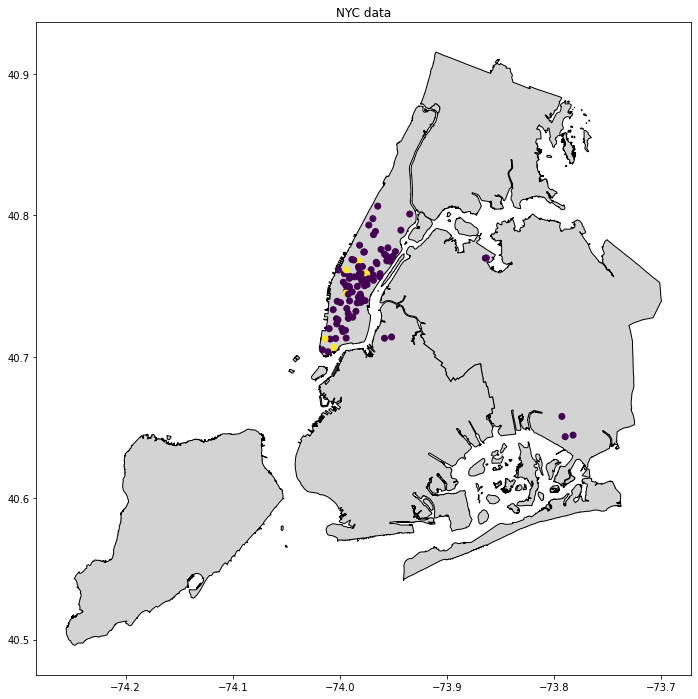

In [10]:
plot_on_ny_map(df, points=100, colored=True, color_col='rain')

# Applying DBSCAN

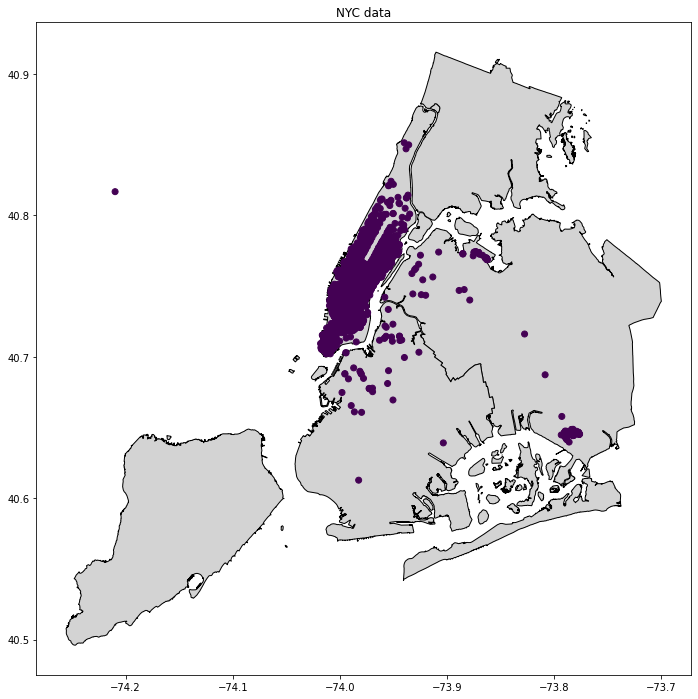

In [11]:
from sklearn.cluster import DBSCAN

X = df[['startLatitude', 'startLongitude']][:2000]
dbscan = DBSCAN().fit(X)
labels = pd.DataFrame(dbscan.labels_, columns=['label'])
result = X.join(labels)
plot_on_ny_map(result, points=2000, colored=True, color_col='label')

Only one cluster has been identified.

In [12]:
print(labels['label'].unique())

[0]


### Finding a useful value for $\epsilon$

Applying the elbow method.

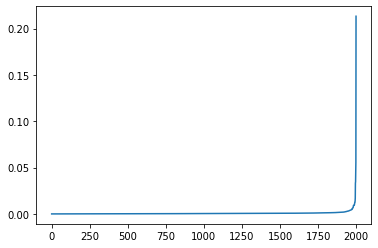

In [13]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
None

Optimal values for $\epsilon$ seem to be between 0.00 and 0.05.

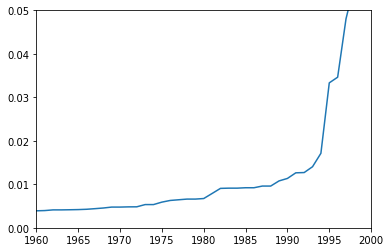

In [14]:
plt.plot(distances)
plt.xlim([1960, 2000])
plt.ylim([0, 0.05])
None

The maximum curvature is reached at $\epsilon \approx 0.013$.

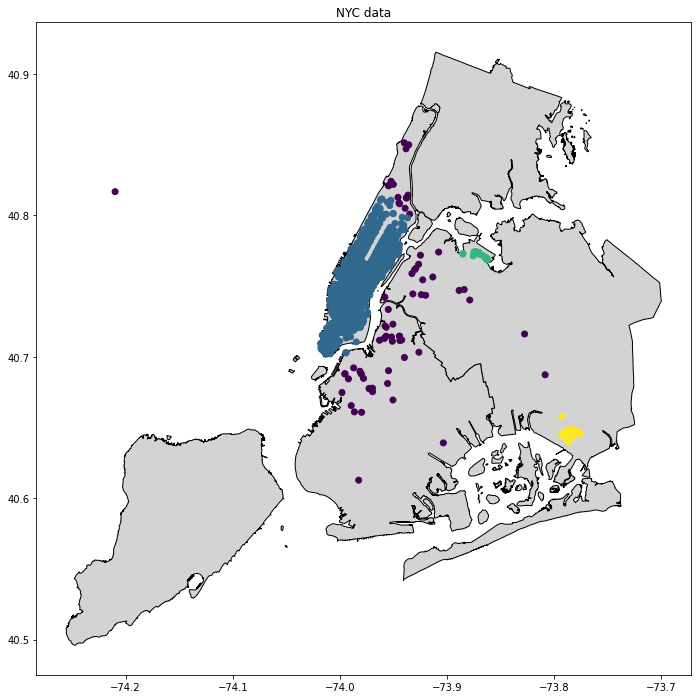

In [15]:
X = df[['startLatitude', 'startLongitude']][:2000]
dbscan = DBSCAN(eps=0.013, min_samples=30).fit(X)
labels = pd.DataFrame(dbscan.labels_, columns=['label'])
result = X.join(labels)
plot_on_ny_map(result, points=2000, colored=True, color_col='label')

4 clusters and 70 outliers have been identified.

In [16]:
print('Clusters: ' + str(labels['label'].unique()))
for i, x in zip(labels['label'].unique(), labels['label'].value_counts()):
    print(str(i) + '\t:\t' + str(x))

Clusters: [ 0 -1  2  1]
0	:	1832
-1	:	70
2	:	53
1	:	45


# Applying OPTICS

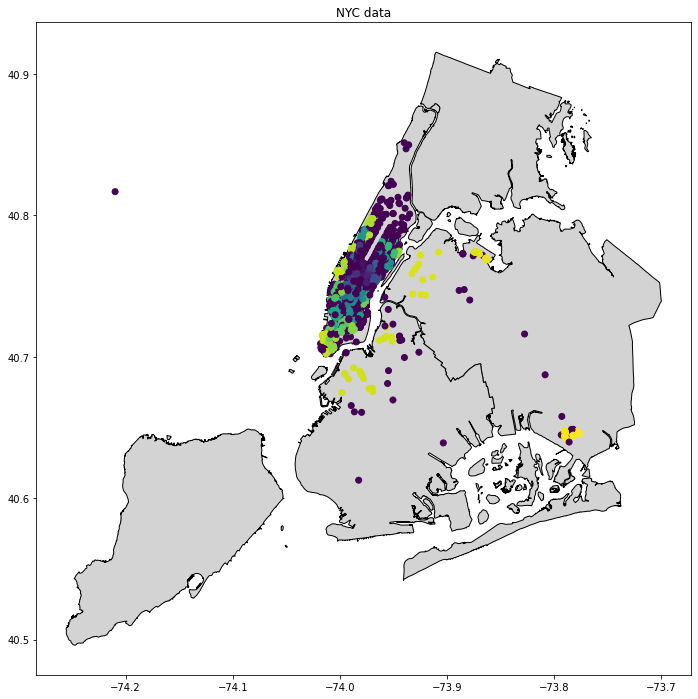

In [17]:
from sklearn.cluster import OPTICS

X = df[['startLatitude', 'startLongitude']][:2000]
dbscan = OPTICS().fit(X)
labels = pd.DataFrame(dbscan.labels_, columns=['label'])
result = X.join(labels)
plot_on_ny_map(result, points=2000, colored=True, color_col='label')

# Applying K-Means
The sci-kit learn implementation defaults to $k = 8$ clusters.

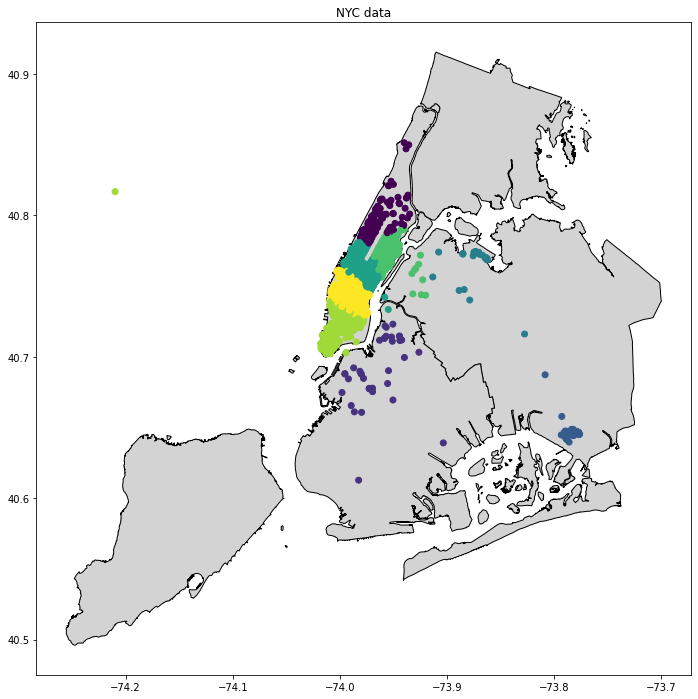

In [18]:
from sklearn.cluster import KMeans

X = df[['startLatitude', 'startLongitude']][:2000]
dbscan = KMeans().fit(X)
labels = pd.DataFrame(dbscan.labels_, columns=['label'])
result = X.join(labels)
plot_on_ny_map(result, points=2000, colored=True, color_col='label')